In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
train_data = pd.read_csv('train_jqd04QH.csv')
test_data = pd.read_csv('test_KaymcHn.csv')

In [4]:
train_data.shape, test_data.shape

((18359, 14), (15021, 13))

In [161]:
data = pd.concat([train_data, test_data], ignore_index = True)
data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0.0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0.0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0.0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0.0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1.0


In [7]:
data.shape

(33380, 14)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33380 entries, 0 to 33379
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             33380 non-null  int64  
 1   city                    33380 non-null  object 
 2   city_development_index  33380 non-null  float64
 3   gender                  25894 non-null  object 
 4   relevent_experience     33380 non-null  object 
 5   enrolled_university     32759 non-null  object 
 6   education_level         32528 non-null  object 
 7   major_discipline        28149 non-null  object 
 8   experience              33277 non-null  object 
 9   company_size            24550 non-null  object 
 10  company_type            24011 non-null  object 
 11  last_new_job            32709 non-null  object 
 12  training_hours          33380 non-null  int64  
 13  target                  18359 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [162]:
cat_cols = ['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job']
num_cols = ['enrollee_id', 'city_development_index', 'training_hours', 'target']

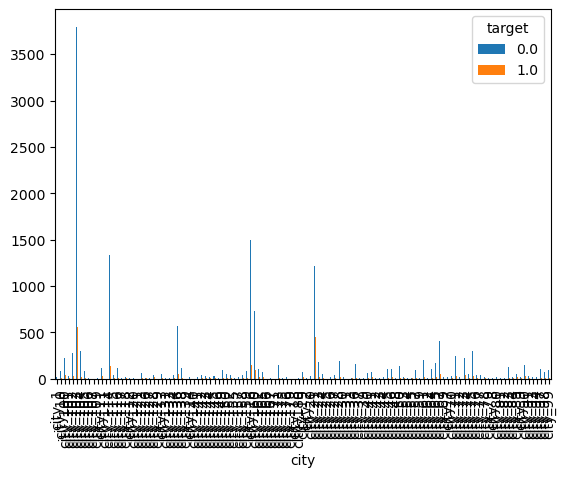

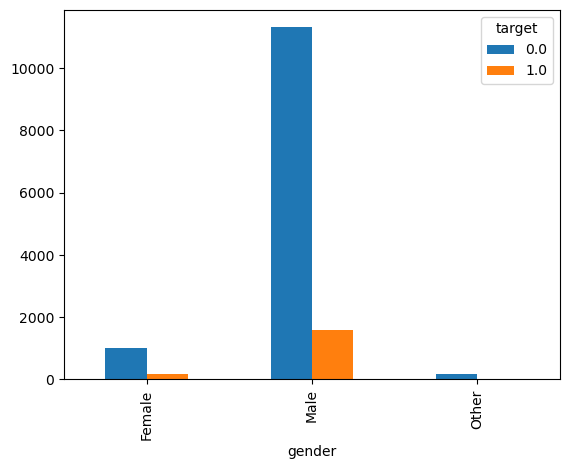

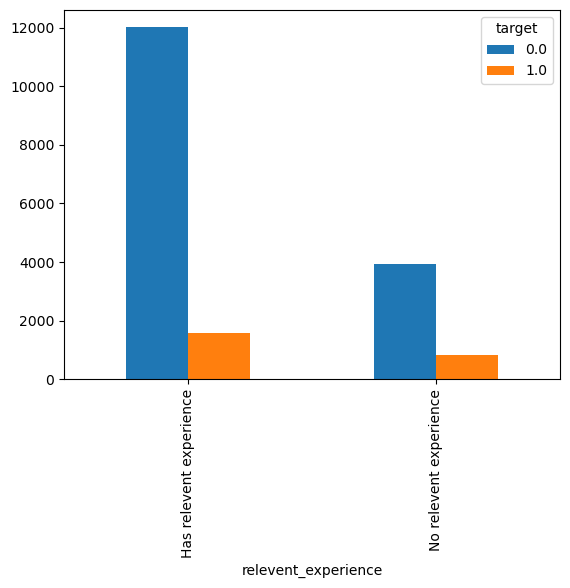

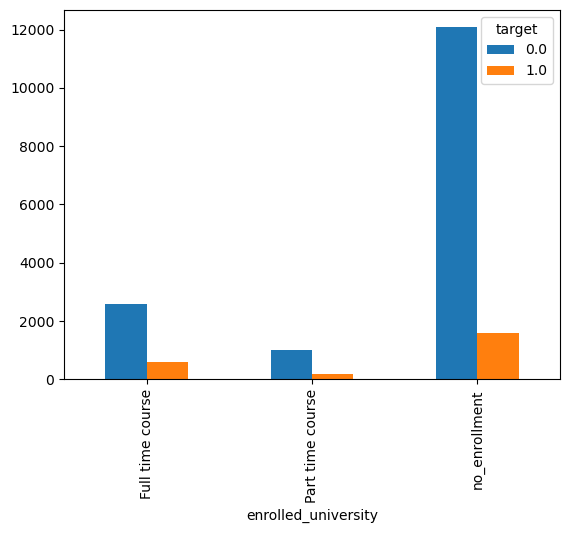

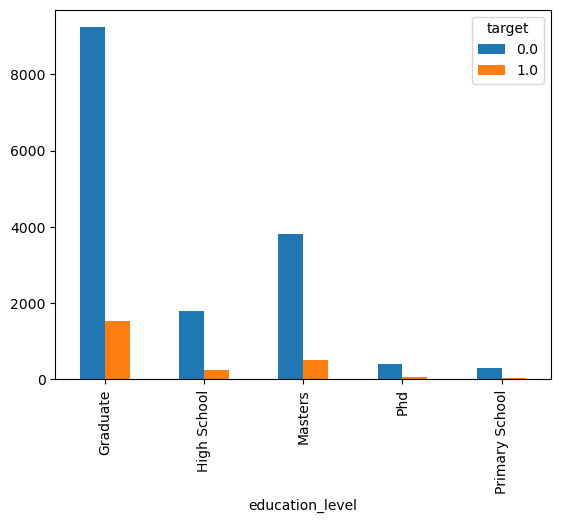

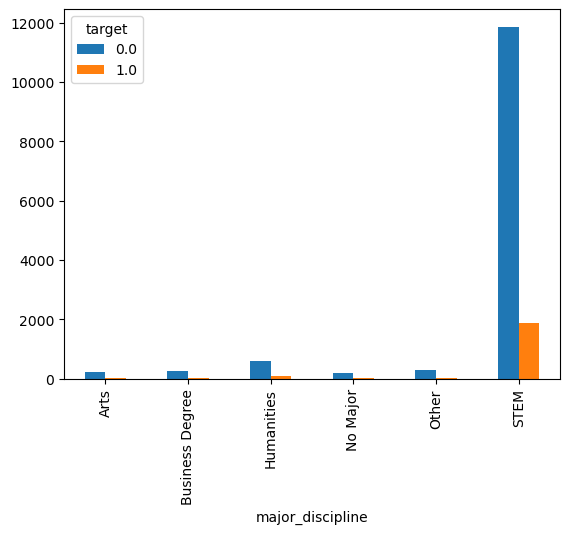

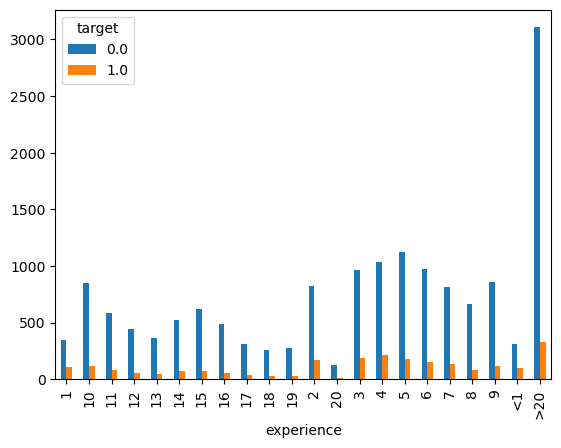

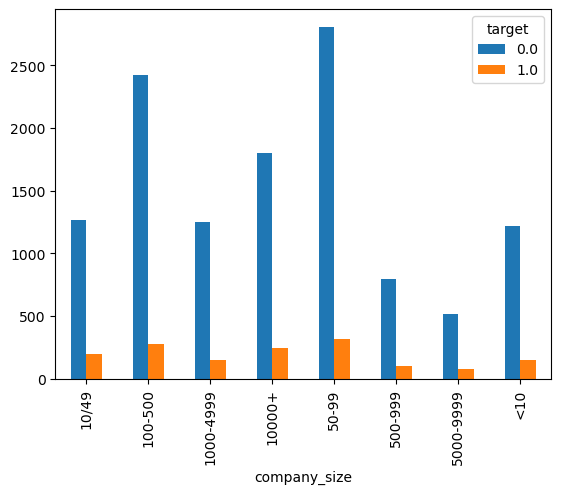

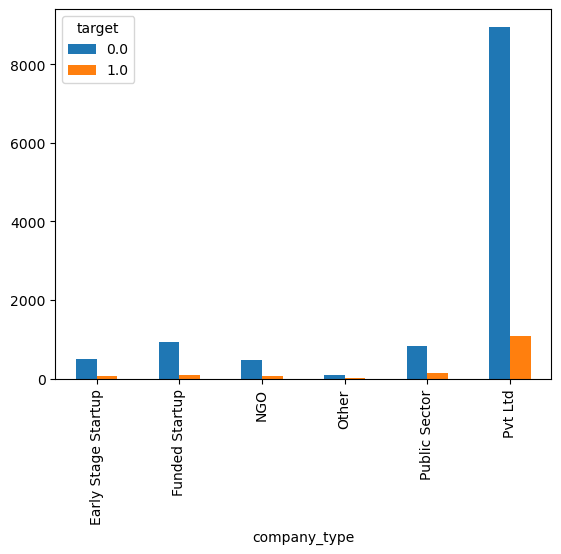

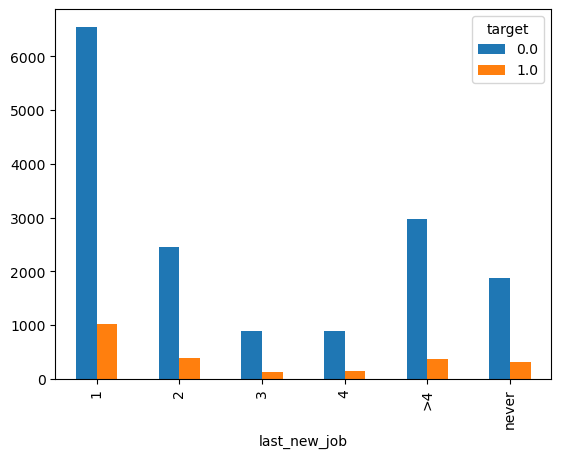

In [23]:
# Cat vs Target Columns
for i in cat_cols:
    pd.crosstab(data.loc[:, i], data.target).plot(kind = 'bar');
    
plt.show()

In [163]:
# city
mapped = data.city.value_counts(normalize =  True).to_dict()
data['city'] = data.city.map(mapped)

In [146]:
data.isnull().sum()

enrollee_id                   0
city                          0
city_development_index        0
gender                     7486
relevent_experience           0
enrolled_university         621
education_level             852
major_discipline           5231
experience                  103
company_size               8830
company_type               9369
last_new_job                671
training_hours                0
target                    15021
dtype: int64

In [164]:
def bins(x):
    if (x <= 8345):
        return '25<'
    elif (x <= 16690):
        return '50<'
    elif (x <= 25035):
        return '75<'
    else:
        return '100'
    
data['bins'] = data.enrollee_id.apply(bins)

<Axes: xlabel='bins'>

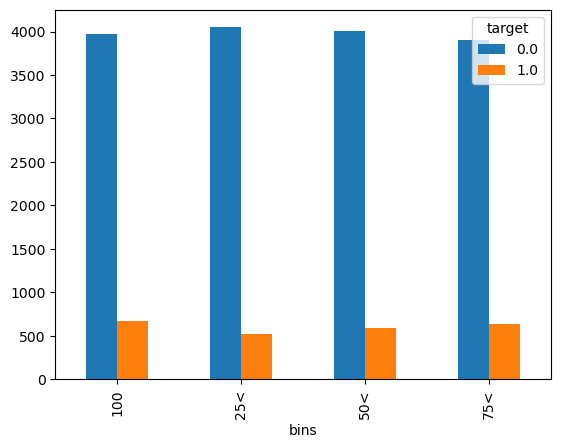

In [148]:
# Through Visulaisation this feature looks unimportant or more congurent
# let's check statistically
pd.crosstab(data.bins,data.target).plot(kind = 'bar')

In [165]:
# H0: That bins from enrollee_id and target are Independent
# H1: That bins from enrollee_id and target are Dependent
test_stats, p_value, df, exp_freq = stats.chi2_contingency(pd.crosstab(data.bins,data.target))
print(p_value)
if(p_value > 0.05):
    print('Fail to Reject Null Hypothesis')
else:
    print('Reject Null Hypothesis')
    
# Bins and taget are related

3.652241533093018e-05
Reject Null Hypothesis


In [150]:
# Missing Value
data.isnull().sum()

enrollee_id                   0
city                          0
city_development_index        0
gender                     7486
relevent_experience           0
enrolled_university         621
education_level             852
major_discipline           5231
experience                  103
company_size               8830
company_type               9369
last_new_job                671
training_hours                0
target                    15021
bins                          0
dtype: int64

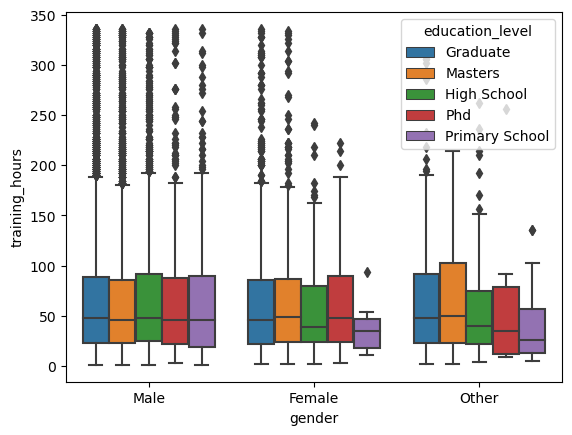

In [59]:
sns.boxplot(x = 'gender', y = 'training_hours', hue = 'education_level', data = data);

In [82]:
pd.crosstab(index = data['education_level'], columns = data['major_discipline'], values = data['gender']
           , aggfunc = 'count')

major_discipline,Arts,Business Degree,Humanities,No Major,Other,STEM
education_level,,,,,,
Graduate,293.0,319.0,639.0,275.0,399.0,13511.0
Masters,53.0,123.0,323.0,40.0,126.0,5402.0
Phd,6.0,7.0,35.0,NaN,14.0,640.0


In [166]:
data_copy = data.dropna()

In [167]:
# Use the Machine Learning to impute missing values
# y = enrolled_university

X = data_copy.drop(['target','enrollee_id', 'enrolled_university'], axis = 1)
y = data_copy['enrolled_university']

In [168]:
missing_value_index = data.loc[data.enrolled_university.isnull()].index

In [169]:
newX = pd.get_dummies(X, drop_first = True)

test_set = data.drop(['target','enrollee_id', 'enrolled_university'], axis = 1)
final_test_set = pd.get_dummies(test_set, drop_first = True)
final_test_set.drop(['education_level_High School','education_level_Primary School'], axis = 1, inplace = True)

rf = RandomForestClassifier()
prediction = rf.fit(newX,y).predict(final_test_set)

#repeater = 0
#for i in missing_value_index:
 #   data.loc[i, 'enrolled_university'] = prediction[repeater]
  #  repeater +=1

(9287, 167)

In [170]:
mapped = dict(zip(final_test_set.index, prediction))
data['enrolled_university'] = np.where(data.enrolled_university.isnull(),data.index.map(mapped),
         data.enrolled_university)

In [171]:
data.isnull().sum()

enrollee_id                   0
city                          0
city_development_index        0
gender                     7486
relevent_experience           0
enrolled_university           0
education_level             852
major_discipline           5231
experience                  103
company_size               8830
company_type               9369
last_new_job                671
training_hours                0
target                    15021
bins                          0
dtype: int64

In [172]:
cols = ['education_level','major_discipline','experience','company_size','company_type',
        'last_new_job']

for i in cols:
    X = data_copy.drop(['target','enrollee_id', i], axis = 1)
    y = data_copy[i]
    newX = pd.get_dummies(X, drop_first = True)
    
    test_set = data.drop(['target','enrollee_id', i], axis = 1)
    final_test_set = pd.get_dummies(test_set, drop_first = True)
    #final_test_set.drop(['education_level_High School','education_level_Primary School'], axis = 1, inplace = True)

    rf = RandomForestClassifier()
    prediction = rf.fit(newX,y).predict(final_test_set)
    
    mapped = dict(zip(final_test_set.index, prediction))
    data[i] = np.where(data[i].isnull(),data.index.map(mapped),
           data[i])

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- education_level_High School
- education_level_Primary School


enrollee_id                                25178
city                                    0.011594
city_development_index                     0.939
gender                                       NaN
relevent_experience       No relevent experience
enrolled_university                no_enrollment
education_level                         Graduate
major_discipline                            STEM
experience                                     1
company_size                              10000+
company_type                                 NaN
last_new_job                               never
training_hours                                11
target                                       0.0
bins                                         100
Name: 23, dtype: object

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,bins
0,23798,0.005812,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0.0,75<
1,29166,0.007280,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0.0,100
2,46,0.087717,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0.0,25<
3,18527,0.007010,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0.0,75<
4,21751,0.015189,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1.0,75<
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33375,11308,0.006920,0.762,NaN,Has relevent experience,no_enrollment,Masters,STEM,>20,500-999,Pvt Ltd,>4,68,NaN,50<
33376,14612,0.090533,0.624,Male,Has relevent experience,Full time course,Masters,STEM,4,1000-4999,Pvt Ltd,1,320,NaN,50<
33377,33346,0.087717,0.910,Male,Has relevent experience,no_enrollment,High School,NaN,9,1000-4999,Pvt Ltd,4,13,NaN,100
33378,14506,0.007010,0.666,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,1,38,NaN,50<
